### Different compareTrackers() plot-styles and use-cases

This function displays each of the "diagnostic-plots" that are saved in a Tracker's track_log return data. These plots represent the graphical results of the transformation applied to that frame's data.

These plots are stored as np.array's as they're outputs of cv2 functions. So we can display them as images or operate on their data-structure them using image algebra.
 
we'll avoid why/how we got these list-of-frames / list-of-trackers and simply show visually the power of the comparison

In [156]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval,
        subprocBatchOutput, cvtPlot, applyTracker,
        roiSelectScoreWindow, multiPlot, compareTrackers)

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Build pre-req's for calling compareTrackers()
need a tracker, configured and initialized; and need a listGS

In [98]:
DATA_DIR = "../data/misc/books/compare-tracker-gallery-1/"
gs_db = "compareTrackers_orange.db"

# build listGS
testDB = DBInterface(os.path.join(DATA_DIR, gs_db))
listGS = [  pickle.loads(record[1])
            for record in testDB.selectAll()]
print 'frame_indexes=', str([_gs.frameCounter for _gs in listGS])

# build listTrackers
listTrackers = []
for _algoenum in [0,1,2]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    listTrackers.append(_tracker)
print 'algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

frame_indexes= [78, 187, 195, 215, 295, 307]
algo_enums= [0, 1, 2]


### Control the region-of-interest

use roiSelectFunc and expand_factor to change window size

The top frame, marked_frame, is not part of track_log but is generated separately by drawing the results of that gs-object's inputScore (blue) and trackScore (red) data fields. (This can be turned off with bMarkedFrame=False)



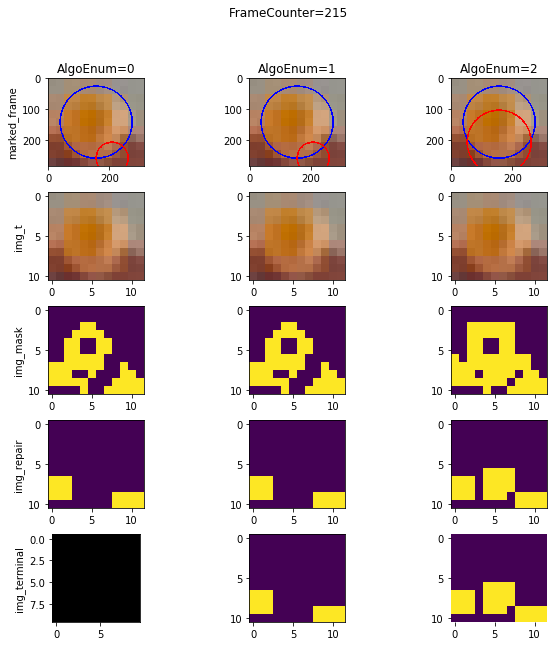

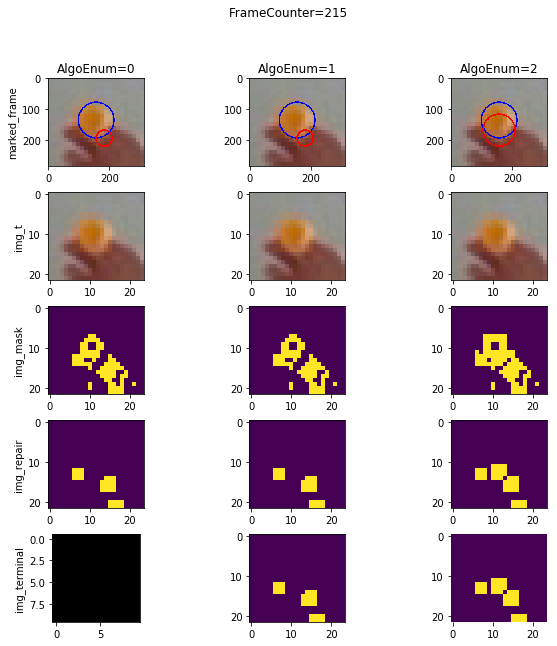

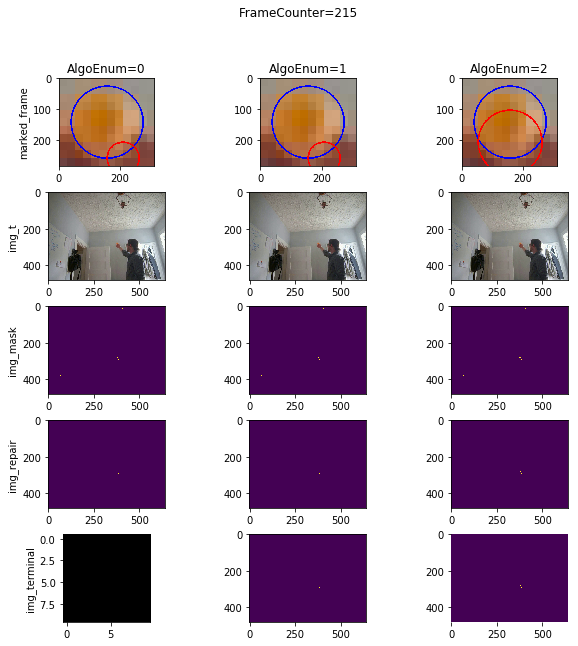

In [99]:
# use roiSelectFunc = roiSelectScoreWindow
compareTrackers([listGS[3]], listTrackers[:3], roiSelectScoreWindow)

# use expand_factor
compareTrackers([listGS[3]], listTrackers[:3], roiSelectScoreWindow, expand_factor=1.0)

# use roiSelectFunc=None for full frame view
compareTrackers([listGS[3]], listTrackers[:3], roiSelectFunc=None)

### Compare trackers with same algo_enum but different paramaters
it works automatically, but we need to overide the default choice to label columns by the algo_enum and instead build out col_titles by hand outside the compareTracker function

In [117]:
# build new trackers: listParams
ALGO_ENUM = 2
listParams = []
for _param in [1,2,3]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(ALGO_ENUM)
    _tracker.setInit(ballColor="orange")
    _tracker.setTrackParams(repair_iterations=_param)
    listParams.append(_tracker)

print 'repair_iters=', str([_tracker.tp_repair_iterations for _tracker in listParams])

#build col_titles
col_titles = [ ('repair_iters=%s' % str(_tracker.tp_repair_iterations)) 
              for _tracker in listParams]
print col_titles

repair_iters= [1, 2, 3]
['repair_iters=1', 'repair_iters=2', 'repair_iters=3']


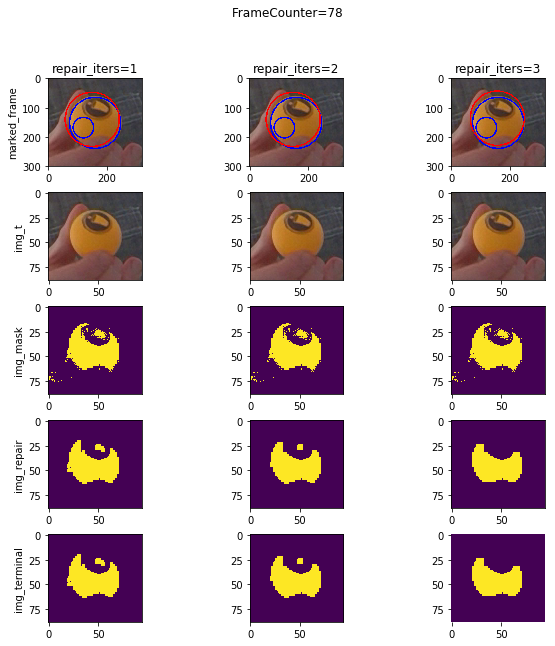

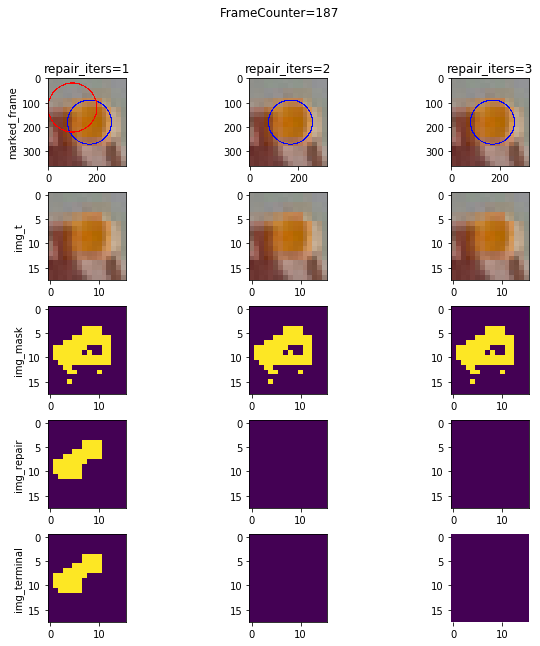

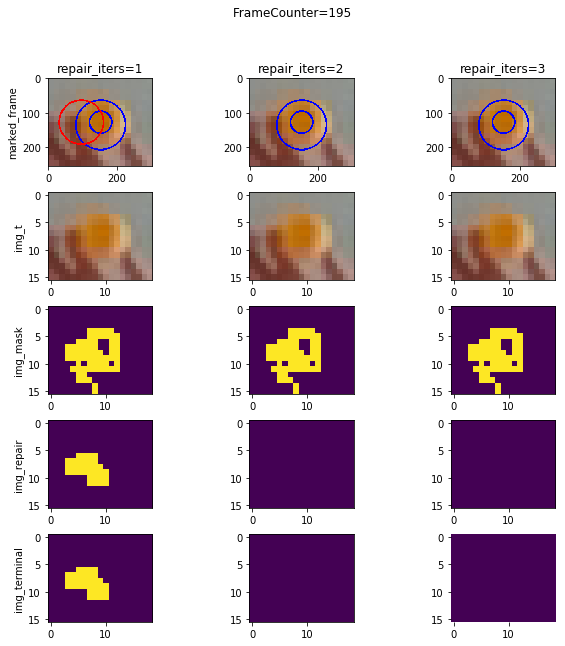

In [118]:
# use expand_factor
# compareTrackers([listGS[3]], listParams[2:], roiSelectScoreWindow, expand_factor=0.3, col_titles = col_titles)
compareTrackers( listGS[:3]
                ,listParams
                ,roiSelectScoreWindow
                ,expand_factor=0.3
                ,col_titles=col_titles
               )

### Pass formatting / size options to image display library
use mutliplot_params = {'figsize':(20,20)}

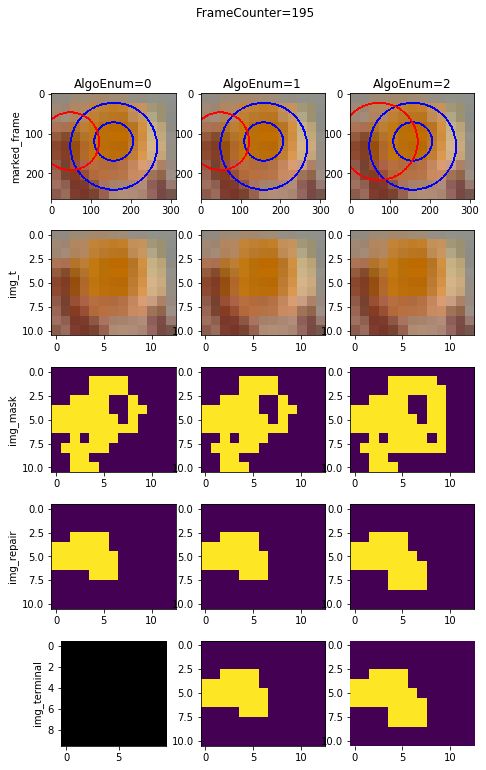

In [123]:
compareTrackers( [listGS[2]]
                ,listTrackers
                ,roiSelectScoreWindow
                ,multiplot_params = {'figsize': (8,12), 'wspace': 0.01}                    
               )

### Use test_stub data return to grab an individual image / diagnostic plot as np.array
useing test_stub=True, the plot image is in the return dict in the 'plot_dict' key

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0   255   510   510   510   510   510   510   510
   510   510   510   765  1020  1275  1530  1530  1530  1530  1530  1530
  1530  1530  1785  2040  2040  2040  2295  2550  2550  2550  2550  2550
  2550  2550  2805  3060  3060  3060  3315  3570  3570  3570  3570  3570
  3570  3570  3825  4080  4335  4590  4845  4845  4845  4845  4845  4845
  5100  5355  5610  5865  6120  6375  6630  6630  6630  6885  6885  6885
  7140  7395  7650  7650  7650  7905  7905  7905  7905  8160  8415  8415
  8670  8925  9180  9435  9690  9690  9690  9690  9945 10200 10455 10710
 10710 10710 10710 10710 10965 10965 10965 11220 11475 11730 11985 12240]


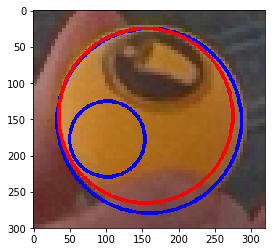

In [127]:
data_dict = compareTrackers([listGS[0]], listTrackers[:3], roiSelectScoreWindow, test_stub=True)

# for display
img1 = data_dict['plot_dict']['marked_frame'][0]
cvtPlot(img1)

#for operation /exploration with the data-structure notebook
data_dict2 = compareTrackers( [listGS[3]], listTrackers, roiSelectScoreWindow, test_stub=True)
img_mask = data_dict2['plot_dict']['img_mask'][0]
print img_mask.cumsum()
    

### Compare trackers with different amount/names for diagnostic plots
 - using blennd_rowtitles=True will keep the exact order of diagnostic-plots, whiule listing them separately for each column on the left-axis
 - without that argument, the function will attempt to align plots with the same name while inserting blanks into the column missing that diagnostic plot
 
In the floowing contrived example, we have three extra diagnostic plots in algo_enum=3 then and algo_enum=2. Those plots are: img_dummy, img_dummy_2, img_terminal_2. We want to see how the plots are handled for ordering and labelling vertically.

In [157]:
# build listTrackers
listTrackers = []
for _algoenum in [0,1,2,3]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    listTrackers.append(_tracker)
print 'algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

algo_enums= [0, 1, 2, 3]


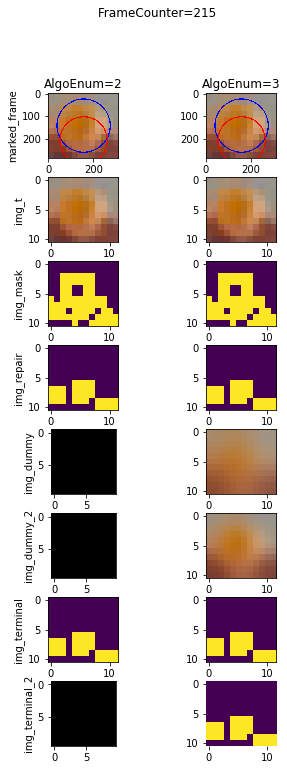

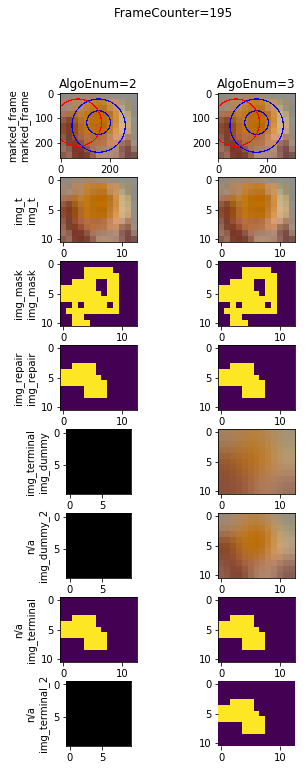

In [159]:
# try to align same-named plots
compareTrackers([listGS[3]], listTrackers[2:], roiSelectScoreWindow
                ,multiplot_params = {'figsize': (5,12)})

# label each plot seprately for each column
compareTrackers([listGS[2]], listTrackers[2:], roiSelectScoreWindow, blend_rowtitles=True
               ,multiplot_params = {'figsize': (5,12)})